In [1]:
### Hayden Gallo
### Bucci Lab
### gLV dFBA extension such that i can fit co-culture and mono-culture data, using least squares and loss function 
### 10/21/24

import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

import time
import joblib
import multiprocessing
from scipy.stats import truncnorm
import copy
from pathlib import Path
import subprocess

### script for running glv_dfba inference
from helper_functions import *

In [44]:
cerillo_test_data = pd.read_csv('/Users/haydengallo/Documents/Bucci_Lab/cerillo_data/averaged_cerillo.csv', index_col=0)

# need .item() appendage for loading as dict not as array
exp_data_dict = np.load('/Users/haydengallo/Documents/Bucci_Lab/cerillo_data/exp_data_dict.npy', allow_pickle=True).item()

cerillo_test_data.shape

cerillo_test_data.head()


,Group_together,Time,OD
0,DO/DO,0,0.001683
1,DO/DO,5,0.001717
2,DO/DO,10,0.003267
3,DO/DO,15,0.004917
4,DO/DO,20,0.006667


In [45]:
exp_data_dict

{'eb_pc_co': [    Time      EB      PC   DO
  0      0  0.0025  0.0021  0.0
  1      5  0.0018  0.0012  0.0
  2     10  0.0033  0.0046  0.0
  3     15  0.0052  0.0078  0.0
  4     20  0.0073  0.0107  0.0
  ..   ...     ...     ...  ...
  88   440  0.6314  0.4365  0.0
  89   445  0.6437  0.4530  0.0
  90   450  0.6554  0.4690  0.0
  91   455  0.6637  0.4859  0.0
  92   460  0.6757  0.5033  0.0
  
  [93 rows x 4 columns],
      Time      EB      PC   DO
  0      0  0.0024  0.0025  0.0
  1      5  0.0026  0.0030  0.0
  2     10  0.0048  0.0054  0.0
  3     15  0.0071  0.0080  0.0
  4     20  0.0094  0.0105  0.0
  ..   ...     ...     ...  ...
  88   440  0.6029  0.4672  0.0
  89   445  0.6184  0.4863  0.0
  90   450  0.6327  0.5058  0.0
  91   455  0.6463  0.5251  0.0
  92   460  0.6590  0.5450  0.0
  
  [93 rows x 4 columns],
      Time      EB      PC   DO
  0      0  0.0020  0.0033  0.0
  1      5  0.0014  0.0019  0.0
  2     10  0.0025  0.0033  0.0
  3     15  0.0038  0.0052  0.0
  4 

In [4]:
co_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PCwEB') | (cerillo_test_data['Group_together'] == 'EBwPC')]
co_culture_data = co_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
co_culture_data.head()

Group_together,Time,EBwPC,PCwEB
0,0,0.002300,0.002633
1,5,0.001933,0.002033
2,10,0.003533,0.004433
3,15,0.005367,0.007000
4,20,0.007333,0.009333


In [5]:
EB_mono_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'EB/EB')]
EB_mono_culture_data = EB_mono_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
EB_mono_culture_data['PC'] = 0

EB_mono_culture_data.head()

list_zero = EB_mono_culture_data['PC']

In [6]:
PC_mono_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PC/PC')]
PC_mono_culture_data = PC_mono_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
PC_mono_culture_data.insert(1, 'EB', list_zero)

PC_mono_culture_data.head()

Group_together,Time,EB,PC/PC
0,0,0,0.002183
1,5,0,0.000917
2,10,0,0.002000
3,15,0,0.003350
4,20,0,0.005033


In [7]:
co_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PCwEB') | (cerillo_test_data['Group_together'] == 'EBwPC')]
co_culture_data = co_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
co_culture_data.head()

Group_together,Time,EBwPC,PCwEB
0,0,0.002300,0.002633
1,5,0.001933,0.002033
2,10,0.003533,0.004433
3,15,0.005367,0.007000
4,20,0.007333,0.009333


In [8]:
### Setup parameters for fitting lsq gLV

init_abun_co = [.002, .002]
EB_init_abun_mono = [.002, 0]
PC_init_abun_mono = [0, 0.002]
### so far must manually set initial values of parameters
### also might want to manually specify bounds too, could be something good 

# monoculture growth rate of EB
r_1 = 0.04198
# monoculture growth rate of P. copri
r_2 = .115
# co culture growth rate of EB
gamma_1 = 5
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0
# intraspecies competition of EB
a_1 = -10
# intraspecies competition of P. copri
a_2 = -2.9


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])

total_sim_time = 460
num_t_steps = 460
### first perform original least squares fit of glv

In [9]:
loss = 1e8
loss_tol = 1

# monoculture growth rate of EB
r_1 = 0.04198
# monoculture growth rate of P. copri
r_2 = .115
# co culture growth rate of EB
gamma_1 = 5
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0
# intraspecies competition of EB
a_1 = -10
# intraspecies competition of P. copri
a_2 = -2.9


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])

total_sim_time = 460
num_t_steps = 460
old_cost = 0
cost_diff = 1
count = 0
'''
while (cost_diff > 1e-4):
    count += 1
    print(count)
    if count == 10:
        break


    glv_out, params_co, time, cost_co = ls_glv_fit(init_abun = init_abun_co, params = params_mono, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=co_culture_data)


    glv_out, params_mono, time, cost_mono = ls_glv_fit(init_abun = init_abun_mono, params = params, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=mono_culture_data)

    total_cost = cost_co + cost_mono
    cost_diff = np.abs(total_cost-old_cost)
    old_cost = total_cost
    print(cost_diff)

'''    

    

'\nwhile (cost_diff > 1e-4):\n    count += 1\n    print(count)\n    if count == 10:\n        break\n\n\n    glv_out, params_co, time, cost_co = ls_glv_fit(init_abun = init_abun_co, params = params_mono, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=co_culture_data)\n\n\n    glv_out, params_mono, time, cost_mono = ls_glv_fit(init_abun = init_abun_mono, params = params, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=mono_culture_data)\n\n    total_cost = cost_co + cost_mono\n    cost_diff = np.abs(total_cost-old_cost)\n    old_cost = total_cost\n    print(cost_diff)\n\n'

In [10]:
abun_list = [init_abun_co, EB_init_abun_mono, PC_init_abun_mono]
microbe_data_list = [co_culture_data, EB_mono_culture_data, PC_mono_culture_data]

print(abun_list)
print(microbe_data_list)

co_culture_data

[[0.002, 0.002], [0.002, 0], [0, 0.002]]
[Group_together  Time     EBwPC     PCwEB
0                  0  0.002300  0.002633
1                  5  0.001933  0.002033
2                 10  0.003533  0.004433
3                 15  0.005367  0.007000
4                 20  0.007333  0.009333
..               ...       ...       ...
88               440  0.657400  0.432033
89               445  0.672133  0.449533
90               450  0.686133  0.467133
91               455  0.698833  0.485300
92               460  0.711533  0.504033

[93 rows x 3 columns], Group_together  Time     EB/EB  PC
0                  0  0.002517   0
1                  5  0.002000   0
2                 10  0.003483   0
3                 15  0.005233   0
4                 20  0.007117   0
..               ...       ...  ..
88               440  0.280050   0
89               445  0.288367   0
90               450  0.296867   0
91               455  0.305617   0
92               460  0.314900   0

[93 rows x 3 columns]

Group_together,Time,EBwPC,PCwEB
0,0,0.002300,0.002633
1,5,0.001933,0.002033
2,10,0.003533,0.004433
3,15,0.005367,0.007000
4,20,0.007333,0.009333
...,...,...,...
88,440,0.657400,0.432033
89,445,0.672133,0.449533
90,450,0.686133,0.467133
91,455,0.698833,0.485300


In [11]:
def ode_model_resid(params, microbe_data, init_abun):
    return (
        microbe_data.iloc[:,1:] - odeint(generalized_gLV, y0 = init_abun, t=microbe_data['Time'], args = (params,))
    ).values.flatten()

def total_loss(params, microbe_data_list, abun_list):
    total_loss_sq = 0
    for i in range(0, len(abun_list)):
        loss = ode_model_resid(params=params, microbe_data=microbe_data_list[i], init_abun=abun_list[i])
        total_loss_sq += np.sum(loss**2)

    return total_loss_sq


In [12]:
total_loss_test = total_loss(params=params, microbe_data_list=microbe_data_list, abun_list=abun_list)
print(total_loss_test)
print(params)


12.577422256782548
[  0.04198   0.115     5.        0.      -10.       -2.9    ]


In [13]:
# monoculture growth rate of EB
r_1 = 0.5
# monoculture growth rate of P. copri
r_2 = .5
# co culture growth rate of EB
gamma_1 = 4
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0.1
# intraspecies competition of EB
a_1 = -7
# intraspecies competition of P. copri
a_2 = -1


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])



bnds = ((0, 10), (0, 10), (0, 10), (-5, 5), (-10, 0), (-10, 0))
results = minimize(total_loss, params, args=(microbe_data_list, abun_list), bounds=bnds, tol = 1e-10)

In [14]:
new_params = results.x
print(new_params)

[ 0.01507112  0.01408723  0.04890572  0.00162419 -0.04596518 -0.02082481]


In [15]:
time = np.arange(0, 460,1)

In [16]:
x_y_co = odeint(generalized_gLV, y0 = init_abun_co, t=time, args = (new_params,))
x_y_EB_mono = odeint(generalized_gLV, y0 = EB_init_abun_mono, t=time, args = (new_params,))
x_y_PC_mono = odeint(generalized_gLV, y0 = PC_init_abun_mono, t=time, args = (new_params,))

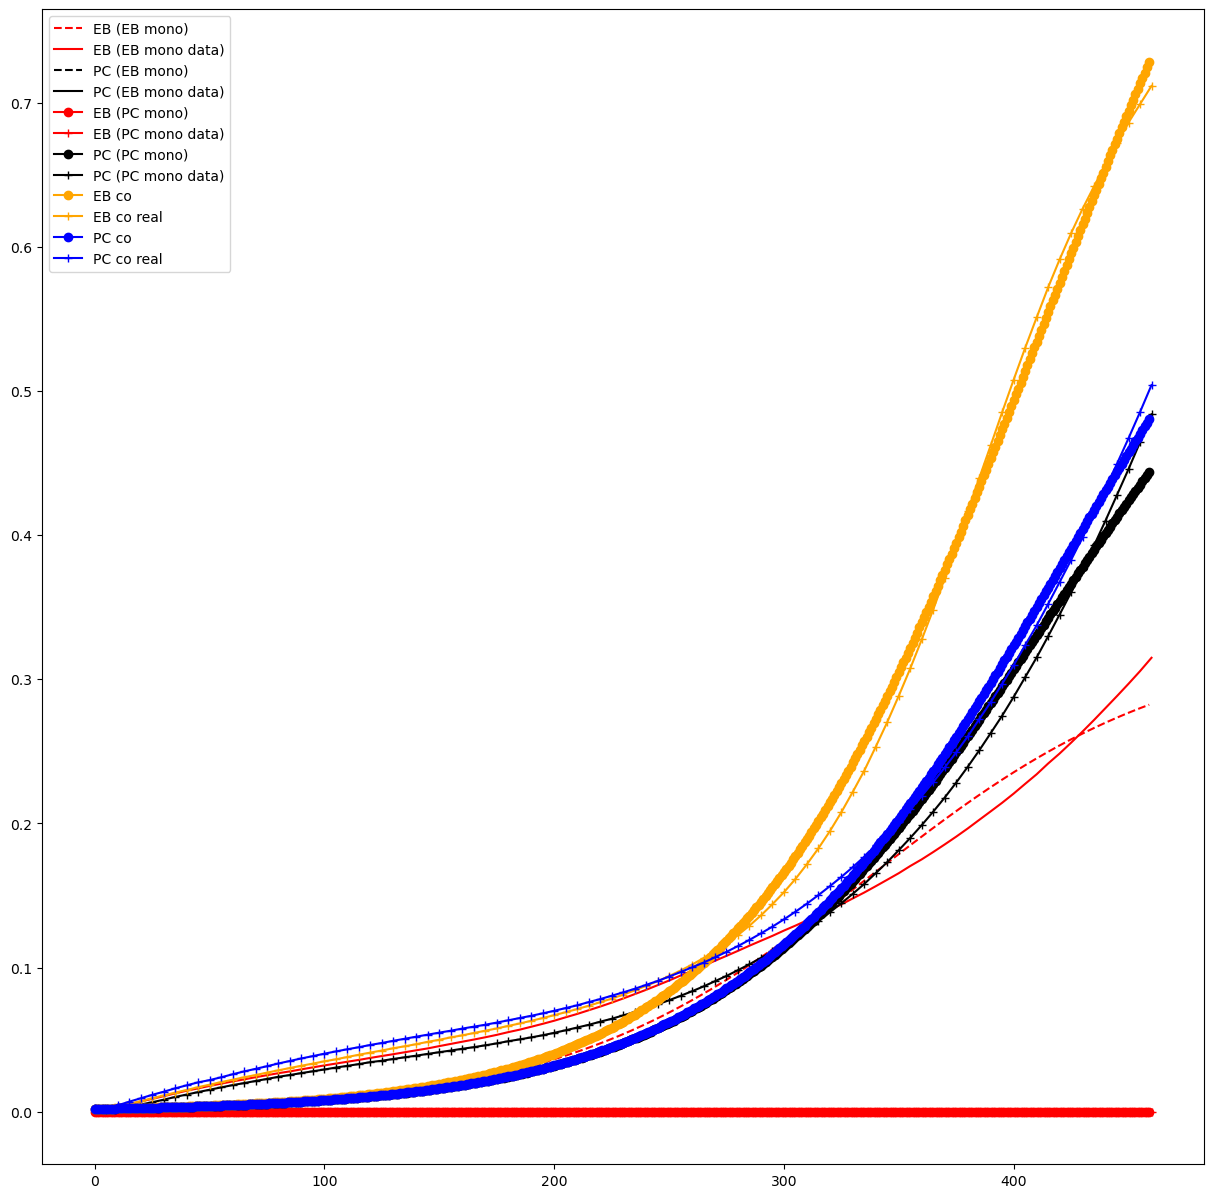

In [17]:
fig, axs = plt.subplots(figsize = (15,15))

plt.plot(time, x_y_EB_mono[:,0], label = 'EB (EB mono)', color = 'red', linestyle ='--')
plt.plot(EB_mono_culture_data['Time'], EB_mono_culture_data['EB/EB'], label = 'EB (EB mono data)', color = 'red')

plt.plot(time, x_y_EB_mono[:,1], label = 'PC (EB mono)', color = 'black', linestyle ='--')
plt.plot(EB_mono_culture_data['Time'], EB_mono_culture_data['PC'], label = 'PC (EB mono data)', color = 'black')

plt.plot(time, x_y_PC_mono[:,0], label = 'EB (PC mono)', color = 'red', marker ='o')
plt.plot(PC_mono_culture_data['Time'], PC_mono_culture_data['EB'], label = 'EB (PC mono data)', color = 'red', marker = '+')

plt.plot(time, x_y_PC_mono[:,1], label = 'PC (PC mono)', color = 'black', marker ='o')
plt.plot(PC_mono_culture_data['Time'], PC_mono_culture_data['PC/PC'], label = 'PC (PC mono data)', color = 'black', marker = '+')

plt.plot(time, x_y_co[:,0], label = 'EB co', color = 'orange', marker = 'o')
plt.plot(co_culture_data['Time'], co_culture_data['EBwPC'], label = 'EB co real', color = 'orange', marker = '+')

plt.plot(time, x_y_co[:,1], label = 'PC co', color = 'blue', marker = 'o')
plt.plot(co_culture_data['Time'], co_culture_data['PCwEB'], label = 'PC co real', color = 'blue', marker = '+')

#plt.plot(mono_culture_data['Time'], mono_culture_data['EB/EB'], label = 'EB mono real', color = 'red')

plt.legend()
plt.show()


In [18]:
new_params

array([ 0.01507112,  0.01408723,  0.04890572,  0.00162419, -0.04596518,
       -0.02082481])

In [19]:
@as_op(itypes=[pt.dvector, pt.dvector, pt.dmatrix], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(params_ls, init_abun, microbe_data):

    time_values = microbe_data[:,0]
    #print(time_values)

    return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))

def bayesian_glv_setup(params_init, microbe_data_list, abun_list):

    #params = results.x  # least squares solution used to inform the priors
    with pm.Model() as model:
        # Priors
        r_1 = pm.TruncatedNormal("r_1", mu=params_init[0], sigma=0.1, lower=0, initval=params_init[0])
        r_2 = pm.TruncatedNormal("r_2", mu=params_init[1], sigma=0.01, lower=0, initval=params_init[1])
        ### Should I make gamma normally distributed? or at least gamma_2 for PC due to 
        gamma_1 = pm.TruncatedNormal("gamma_1", mu=params_init[2], sigma=0.1, lower=0, initval=params_init[2])
        gamma_2 = pm.TruncatedNormal("gamma_2", mu=params_init[3], sigma=0.01, lower=0, initval=params_init[3])
        a_1 = pm.TruncatedNormal("a_1", mu=params_init[4], sigma=1, upper=0, initval=params_init[4])
        a_2 = pm.TruncatedNormal("a_2", mu=params_init[5], sigma=1, upper=0, initval=params_init[5])

        #for i in range(0, len(microbe_data_list)):
        #    # Likelihood for each dataset, with a unique sigma per dataset
        #    sigma = pm.HalfNormal(f"sigma_{i}", 10)

        # Loop over each dataset
        for i, microbe_data in enumerate(microbe_data_list):
            # ODE solution for each dataset
            ode_solution = pytensor_forward_model_matrix(
                pm.math.stack([r_1, r_2, gamma_1, gamma_2, a_1, a_2]), pm.math.stack(abun_list[i]), pt.as_tensor(microbe_data.values)
            )
            sigma = pm.HalfNormal(f"sigma_{i}", 10)

            pm.Normal(f"Y_obs_{i}", mu=ode_solution, sigma=sigma, observed=microbe_data.iloc[:,1:].values)

        return model




def bayesian_glv_run(model, num_samples, chains):
    # Variable list to give to the sample step parameter
    vars_list = list(model.values_to_rvs.keys())[:7]+[list(model.values_to_rvs.keys())[8]]+[list(model.values_to_rvs.keys())[10]]

    sampler = "DEMetropolisZ"
    tune = draws = num_samples
    with model:
        trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=chains, cores = 10)
    trace = trace_DEMZ
    #az.summary(trace)

    return trace

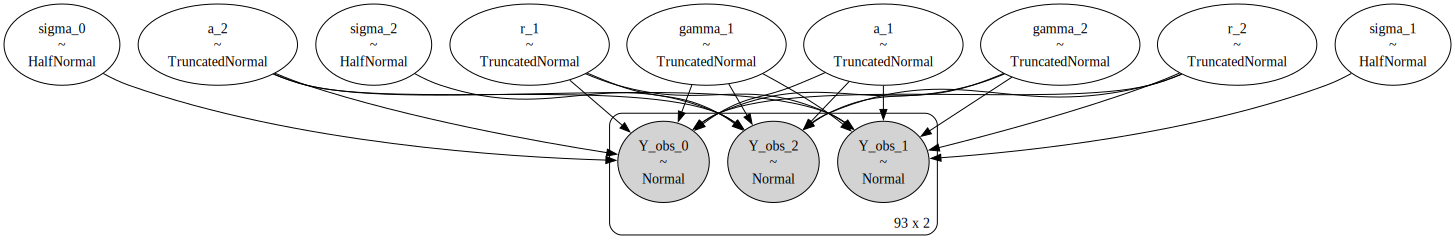

In [20]:
model = bayesian_glv_setup(params_init=new_params, microbe_data_list=microbe_data_list, abun_list=abun_list)
(pm.model_to_graphviz(model=model))

In [21]:
#trace = bayesian_glv_run(model=model, num_samples=50000, chains =10)

In [22]:
#az.summary(trace)

In [23]:
### redoing with 3 species, EB, PC, DO

### need to incorporate the DO data now 


co_culture_df_DO_PC = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PCwDO') | (cerillo_test_data['Group_together'] == 'DOwPC')]
co_culture_data_DO_PC = co_culture_df_DO_PC.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
co_culture_data_DO_PC.insert(1, 'EB', list_zero)
co_culture_data_DO_PC = co_culture_data_DO_PC[['Time', 'EB', 'PCwDO', 'DOwPC']]
co_culture_data_DO_PC.head()




Group_together,Time,EB,PCwDO,DOwPC
0,0,0,0.001900,0.002200
1,5,0,0.002067,0.002067
2,10,0,0.003833,0.003367
3,15,0,0.005700,0.004933
4,20,0,0.007833,0.006767


In [24]:
### monoculture data for DO 

mono_culture_df_DO = cerillo_test_data[(cerillo_test_data['Group_together'] == 'DO/DO')]
mono_culture_df_DO = mono_culture_df_DO.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
mono_culture_df_DO.insert(1, 'EB', list_zero)
mono_culture_df_DO.insert(2, 'PC', list_zero)
mono_culture_df_DO.head()


Group_together,Time,EB,PC,DO/DO
0,0,0,0,0.001683
1,5,0,0,0.001717
2,10,0,0,0.003267
3,15,0,0,0.004917
4,20,0,0,0.006667


In [25]:
# add DO to mono PC and EB

EB_mono_culture_data.insert(3, 'DO', list_zero)
PC_mono_culture_data.insert(3, 'DO', list_zero)

EB_mono_culture_data.head()

Group_together,Time,EB/EB,PC,DO
0,0,0.002517,0,0
1,5,0.002000,0,0
2,10,0.003483,0,0
3,15,0.005233,0,0
4,20,0.007117,0,0


In [26]:
### Add DO data to coculture of PC and EB

co_culture_data.insert(3, 'DO', list_zero)
co_culture_data.head()

Group_together,Time,EBwPC,PCwEB,DO
0,0,0.002300,0.002633,0
1,5,0.001933,0.002033,0
2,10,0.003533,0.004433,0
3,15,0.005367,0.007000,0
4,20,0.007333,0.009333,0


In [27]:
def multi_spec_gLV(X, t, params):

    ### hmm need to expand this to account for N species, i guess for now I can just expand such that I account for 3 species 
    x, y, z = X 
    r_1, r_2, r_3, gamma_EP, gamma_ED, gamma_PE, gamma_PD, gamma_DE, gamma_DP, a_1, a_2, a_3 =  params

    # EB concentration integrated overtime
    dxdt = x * (r_1 + a_1*x + gamma_EP*y + gamma_ED*z)

    # P. copri concentration integrated overtime 
    dydt = y * (r_2 + a_2*y + gamma_PE*x + gamma_PD*z)

    # Dorea concentration integrated overtime 
    dzdt = z * (r_3 + a_3*z + gamma_DE*x + gamma_DP*y)


    return [dxdt, dydt, dzdt]

In [28]:
def ode_model_resid_multi(params, microbe_data, init_abun):
    return (
        microbe_data.iloc[:,1:] - odeint(multi_spec_gLV, y0 = init_abun, t=microbe_data['Time'], args = (params,))
    ).values.flatten()

def total_loss_multi(params, microbe_data_list, abun_list):
    total_loss_sq = 0
    for i in range(0, len(abun_list)):
        loss = ode_model_resid_multi(params=params, microbe_data=microbe_data_list[i], init_abun=abun_list[i])
        total_loss_sq += np.sum(loss**2)

    return total_loss_sq

In [29]:
len(abun_list)

3

In [71]:
### Initial abundances 


init_abun_co_EB_PC = [.002, .002, 0]
init_abun_co_PC_DO = [0, .002, 0.002]
EB_init_abun_mono = [.002, 0, 0]
PC_init_abun_mono = [0, 0.002, 0]
DO_init_abun_mono = [0, 0, 0.002]



abun_list = [init_abun_co_EB_PC, init_abun_co_PC_DO, EB_init_abun_mono, PC_init_abun_mono, DO_init_abun_mono]
microbe_data_list = [co_culture_data,co_culture_data_DO_PC, EB_mono_culture_data, PC_mono_culture_data, mono_culture_df_DO]

In [77]:
microbe_data_list = []
for key in exp_data_dict.keys():
    for j in range(0, len(exp_data_dict[key])):
        microbe_data_list.append(exp_data_dict[key][j])

In [76]:
# 3,3,6,6,6

abun_list = [init_abun_co_EB_PC,init_abun_co_EB_PC,init_abun_co_EB_PC,init_abun_co_PC_DO,init_abun_co_PC_DO,init_abun_co_PC_DO,
             EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,
             PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,
             DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono] 

In [105]:
print(len(abun_list), 'and', len(microbe_data_list))

24 and 24


In [93]:
for i in range(0, len(microbe_data_list)):
    print(microbe_data_list[i].head(1))

   Time      EB      PC   DO
0     0  0.0025  0.0021  0.0
   Time      EB      PC   DO
0     0  0.0024  0.0025  0.0
   Time     EB      PC   DO
0     0  0.002  0.0033  0.0
   Time   EB      PC      DO
0     0  0.0  0.0014  0.0023
   Time   EB      PC      DO
0     0  0.0  0.0021  0.0021
   Time   EB      PC      DO
0     0  0.0  0.0022  0.0022
   Time     EB   PC   DO
0     0  0.002  0.0  0.0
   Time      EB   PC   DO
0     0  0.0028  0.0  0.0
   Time      EB   PC   DO
0     0  0.0025  0.0  0.0
   Time      EB   PC   DO
0     0  0.0024  0.0  0.0
   Time      EB   PC   DO
0     0  0.0035  0.0  0.0
   Time      EB   PC   DO
0     0  0.0019  0.0  0.0
   Time   EB     PC   DO
0     0  0.0  0.002  0.0
   Time   EB      PC   DO
0     0  0.0  0.0024  0.0
   Time   EB      PC   DO
0     0  0.0  0.0022  0.0
   Time   EB     PC   DO
0     0  0.0  0.002  0.0
   Time   EB     PC   DO
0     0  0.0  0.003  0.0
   Time   EB      PC   DO
0     0  0.0  0.0015  0.0
   Time   EB   PC      DO
0     0  0.0

In [112]:
### seems as if minimization approach for weakly informative priors breaksdown when using non averaged experimental data 

# monoculture growth rate of EB
r_1 = .15
# monoculture growth rate of P. copri
r_2 = .15
# monoculture growth rate of DO
r_3 = .5
# co culture growth rate of EB with PC
gamma_EP = .05
# co culture growth rate of EB with DO
gamma_ED = 0
# co culture growth rate of PC with EB
gamma_PE = .001
# co culture growth rate of PC with DO
gamma_PD = .001
# co culture growth rate of DO with EB
gamma_DE = 0
# co culture growth rate of DO with PC
gamma_DP = -.05
# intraspecies competition of EB
a_1 = -.05
# intraspecies competition of P. copri
a_2 = -.05
# intraspecies competition of DO
a_3 = 0

bnds = ((0, 1), (0, 1), (0, 1), (-1, 1), (0, 0), (-1, 1), (-1, 1), (0, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0))
params = np.array([r_1, r_2, r_3, gamma_EP, gamma_ED, gamma_PE, gamma_PD, gamma_DE, gamma_DP, a_1, a_2, a_3])

In [113]:
total_loss_test = total_loss_multi(params=params, microbe_data_list=microbe_data_list, abun_list=abun_list)
print(total_loss_test)
print(params)

2.4015147607655665e+194
[ 0.15   0.15   0.5    0.05   0.     0.001  0.001  0.    -0.05  -0.05
 -0.05   0.   ]


In [114]:
results = minimize(total_loss_multi, params, args=(microbe_data_list[:10], abun_list[:10]), bounds=bnds, tol = 1e-30)

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_2562/2743146037.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = x * (r_1 + a_1*x + gamma_EP*y + gamma_ED*z)
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_2562/2743146037.py:11: RuntimeWarning: overflow encountered in scalar multiply
  dydt = y * (r_2 + a_2*y + gamma_PE*x + gamma_PD*z)
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_2562/2743146037.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  dydt = y * (r_2 + a_2*y + gamma_PE*x + gamma_PD*z)
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_2562/2743146037.py:14: RuntimeWarning: invalid value encountered in scalar multiply
  dzdt = z * (r_3 + a_3*z + gamma_DE*x + gamma_DP*y)
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_2562/2743146037.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dzdt = z * (r_3 + a_3*z + gamma_DE*x + gamma_DP*y)
/var/folders/5n/y6k0c8y951n38r8ccc6t

In [115]:
new_params = results.x
print(new_params)

[ 0.01506156  0.01410981  0.01519069  0.04873413  0.          0.0015145
  0.00170333  0.         -0.03227258 -0.04586511 -0.02085249 -0.01264688]


In [ ]:
[ 0.01506192  0.01410974  0.0151906   0.04874128  0.          0.00151483
  0.00170373  0.         -0.03227239 -0.04587137 -0.02085214 -0.01264632]

In [133]:
x_y_co_EB_PC = odeint(multi_spec_gLV, y0 = init_abun_co_EB_PC, t=time, args = (new_params,))
x_y_co_PC_DO = odeint(multi_spec_gLV, y0 = init_abun_co_PC_DO, t=time, args = (new_params,))
x_y_EB_mono = odeint(multi_spec_gLV, y0 = EB_init_abun_mono, t=time, args = (new_params,))
x_y_PC_mono = odeint(multi_spec_gLV, y0 = PC_init_abun_mono, t=time, args = (new_params,))
x_y_DO_mono = odeint(multi_spec_gLV, y0 = DO_init_abun_mono, t=time, args = (new_params,))

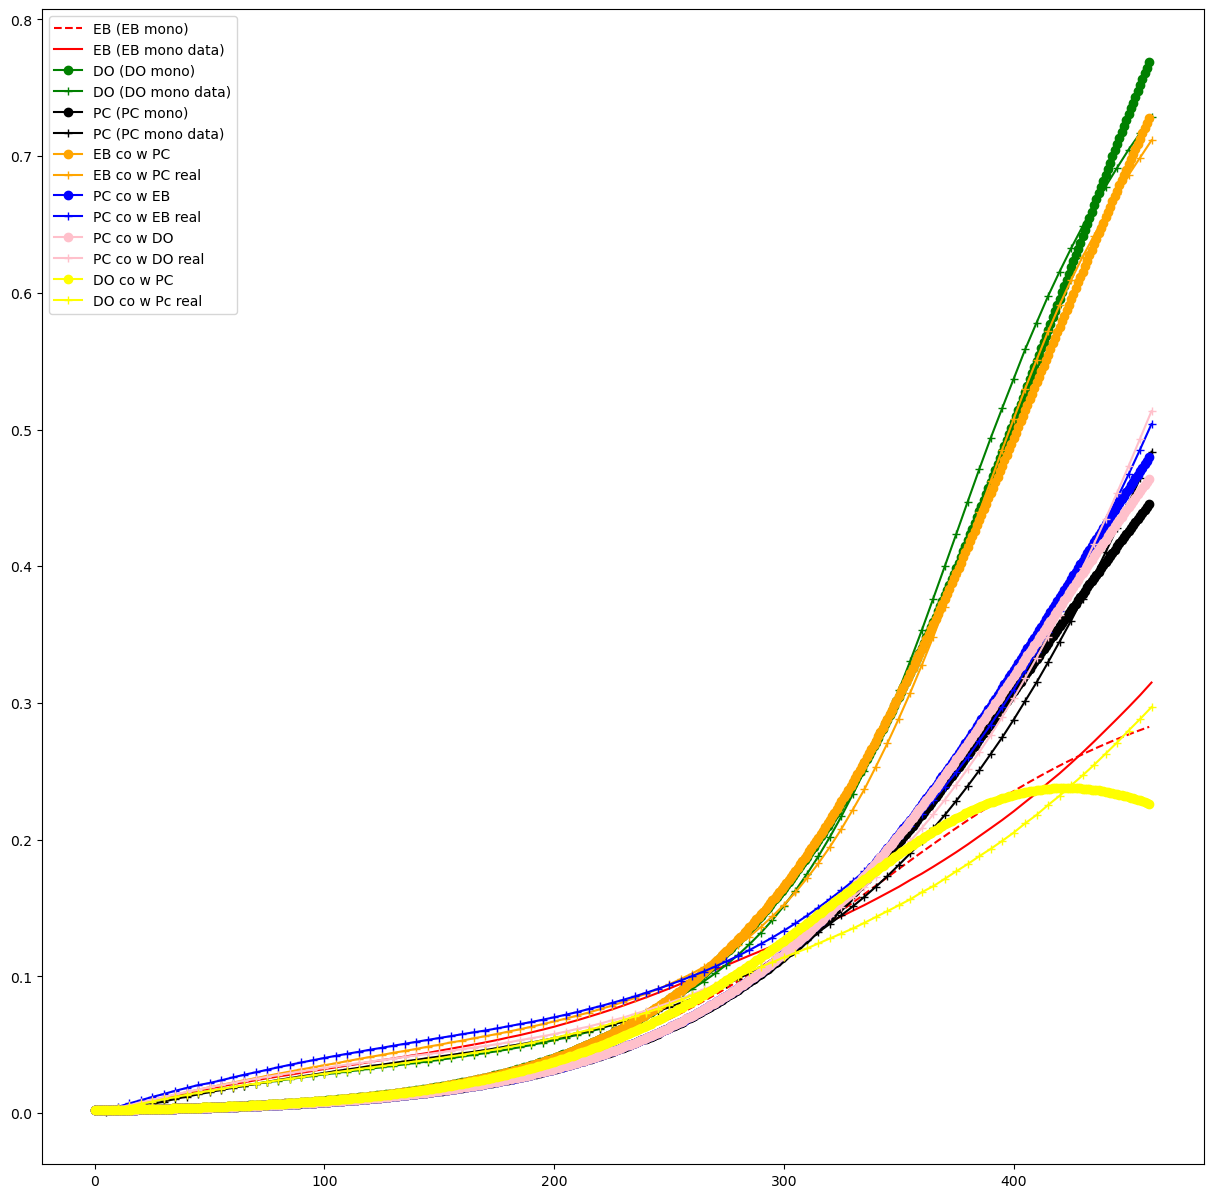

In [284]:
fig, axs = plt.subplots(figsize = (15,15))

plt.plot(time, x_y_EB_mono[:,0], label = 'EB (EB mono)', color = 'red', linestyle ='--')
plt.plot(EB_mono_culture_data['Time'], EB_mono_culture_data['EB/EB'], label = 'EB (EB mono data)', color = 'red')

#plt.plot(time, x_y_EB_mono[:,1], label = 'PC (EB mono)', color = 'black', linestyle ='--')
#plt.plot(EB_mono_culture_data['Time'], EB_mono_culture_data['PC'], label = 'PC (EB mono data)', color = 'black')

#plt.plot(time, x_y_PC_mono[:,0], label = 'EB (PC mono)', color = 'red', marker ='o')
#plt.plot(PC_mono_culture_data['Time'], PC_mono_culture_data['EB'], label = 'EB (PC mono data)', color = 'red', marker = '+')

plt.plot(time, x_y_DO_mono[:,2], label = 'DO (DO mono)', color = 'green', marker ='o')
plt.plot(mono_culture_df_DO['Time'], mono_culture_df_DO['DO/DO'], label = 'DO (DO mono data)', color = 'green', marker = '+')

plt.plot(time, x_y_PC_mono[:,1], label = 'PC (PC mono)', color = 'black', marker ='o')
plt.plot(PC_mono_culture_data['Time'], PC_mono_culture_data['PC/PC'], label = 'PC (PC mono data)', color = 'black', marker = '+')

plt.plot(time, x_y_co_EB_PC[:,0], label = 'EB co w PC', color = 'orange', marker = 'o')
plt.plot(co_culture_data['Time'], co_culture_data['EBwPC'], label = 'EB co w PC real', color = 'orange', marker = '+')

plt.plot(time, x_y_co_EB_PC[:,1], label = 'PC co w EB', color = 'blue', marker = 'o')
plt.plot(co_culture_data['Time'], co_culture_data['PCwEB'], label = 'PC co w EB real', color = 'blue', marker = '+')

plt.plot(time, x_y_co_PC_DO[:,1], label = 'PC co w DO', color = 'pink', marker = 'o')
plt.plot(co_culture_data_DO_PC['Time'], co_culture_data_DO_PC['PCwDO'], label = 'PC co w DO real', color = 'pink', marker = '+')

plt.plot(time, x_y_co_PC_DO[:,2], label = 'DO co w PC', color = 'yellow', marker = 'o')
plt.plot(co_culture_data_DO_PC['Time'], co_culture_data_DO_PC['DOwPC'], label = 'DO co w Pc real', color = 'yellow', marker = '+')


plt.legend()
plt.show()


In [173]:
@as_op(itypes=[pt.dvector, pt.dvector, pt.dmatrix], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix_multi(params_ls, init_abun, microbe_data):

    time_values = microbe_data[:,0]
    #print(time_values)

    return odeint(func=multi_spec_gLV, y0=init_abun, t=time_values, args=(params_ls,))

def bayesian_glv_setup_multi(params_init, microbe_data_list, abun_list):

    #params = results.x  # least squares solution used to inform the priors
    with pm.Model() as model:
        # Priors
        r_1 = pm.TruncatedNormal("r_1", mu=params_init[0], sigma=0.1, lower=0, initval=params_init[0])
        r_2 = pm.TruncatedNormal("r_2", mu=params_init[1], sigma=0.1, lower=0, initval=params_init[1])
        r_3 = pm.TruncatedNormal("r_3", mu=params_init[2], sigma=0.1, lower=0, initval=params_init[2])

        gamma_EP = pm.TruncatedNormal("gamma_EP", mu=params_init[3], sigma=0.1, lower=0, initval=params_init[3])
        #gamma_ED = pm.TruncatedNormal("gamma_ED", mu=params_init[4], sigma=0.1, lower=0, upper=0, initval=params_init[4])
        gamma_PE = pm.TruncatedNormal("gamma_PE", mu=params_init[5], sigma=0.1, lower=0, initval=params_init[5])
        gamma_PD = pm.TruncatedNormal("gamma_PD", mu=params_init[6], sigma=0.1, lower=0, initval=params_init[6])
        #gamma_DE = pm.TruncatedNormal("gamma_DE", mu=params_init[7], sigma=0.1, lower=0, upper=0, initval=params_init[7])
        gamma_DP = pm.TruncatedNormal("gamma_DP", mu=params_init[8], sigma=0.1, upper=0, initval=params_init[8])

        a_1 = pm.TruncatedNormal("a_1", mu=params_init[9], sigma=.1, upper=0, initval=params_init[9])
        a_2 = pm.TruncatedNormal("a_2", mu=params_init[10], sigma=.1, upper=0, initval=params_init[10])
        a_3 = pm.TruncatedNormal("a_3", mu=params_init[11], sigma=.1, upper=0, initval=params_init[11])

        #for i in range(0, len(microbe_data_list)):
        #    # Likelihood for each dataset, with a unique sigma per dataset
        #    sigma = pm.HalfNormal(f"sigma_{i}", 10)

        # Loop over each dataset
        for i, microbe_data in enumerate(microbe_data_list):
            # ODE solution for each dataset
            ode_solution = pytensor_forward_model_matrix_multi(
                pm.math.stack([r_1, r_2, r_3, gamma_EP, gamma_ED, gamma_PE, gamma_PD, gamma_DE, gamma_DP, a_1, a_2, a_3]), pm.math.stack(abun_list[i]), pt.as_tensor(microbe_data.values)
            )
            sigma = pm.HalfNormal(f"sigma_{i}", 10)

            pm.Normal(f"Y_obs_{i}", mu=ode_solution, sigma=sigma, observed=microbe_data.iloc[:,1:].values)

        return model




def bayesian_glv_run_multi(model, num_samples, chains):
    # Variable list to give to the sample step parameter
    #vars_list = list(model.values_to_rvs.keys())[:11]+[list(model.values_to_rvs.keys())[12]]+[list(model.values_to_rvs.keys())[14]]+[list(model.values_to_rvs.keys())[16]]+[list(model.values_to_rvs.keys())[18]]

    # this seems to be a better way to variable select, basically the variables we always want ends with '__' and if we just filter for names that have this we can easily grab correct variable lists
    # https://stackoverflow.com/questions/15403021/regular-expression-to-filter-list-of-strings-matching-a-pattern

    vars_list = [e for e in list(model.values_to_rvs.keys()) if e.name.endswith('__')]

    sampler = "DEMetropolisZ"
    tune = draws = num_samples
    with model:
        trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=chains, cores = 10)
    trace = trace_DEMZ
    #az.summary(trace)

    return trace

In [174]:
### Initial abundances 


init_abun_co_EB_PC = [.002, .002, 0]
init_abun_co_PC_DO = [0, .002, 0.002]
EB_init_abun_mono = [.002, 0, 0]
PC_init_abun_mono = [0, 0.002, 0]
DO_init_abun_mono = [0, 0, 0.002]



abun_list = [init_abun_co_EB_PC, init_abun_co_PC_DO, EB_init_abun_mono, PC_init_abun_mono, DO_init_abun_mono]
microbe_data_list = [co_culture_data,co_culture_data_DO_PC, EB_mono_culture_data, PC_mono_culture_data, mono_culture_df_DO]

In [178]:
microbe_data_list = []
for key in exp_data_dict.keys():
    for j in range(0, len(exp_data_dict[key])):
        microbe_data_list.append(exp_data_dict[key][j])

In [179]:
# 3,3,6,6,6

abun_list = [init_abun_co_EB_PC,init_abun_co_EB_PC,init_abun_co_EB_PC,init_abun_co_PC_DO,init_abun_co_PC_DO,init_abun_co_PC_DO,
             EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,EB_init_abun_mono,
             PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,PC_init_abun_mono,
             DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono,DO_init_abun_mono] 

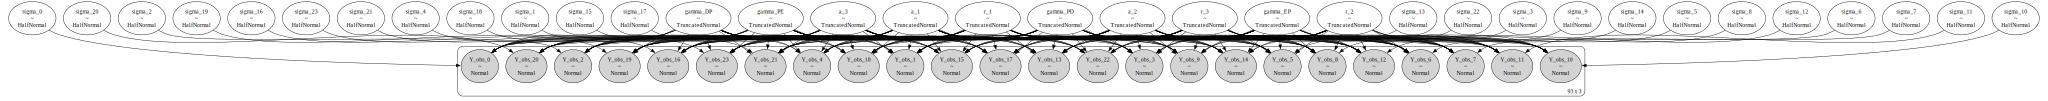

In [180]:
model = bayesian_glv_setup_multi(params_init=new_params, microbe_data_list=microbe_data_list, abun_list=abun_list)
(pm.model_to_graphviz(model=model))

In [181]:
trace = bayesian_glv_run_multi(model=model, num_samples=1000, chains =10)

Multiprocess sampling (10 chains in 10 jobs)
DEMetropolisZ: [r_1, r_2, r_3, gamma_EP, gamma_PE, gamma_PD, gamma_DP, a_1, a_2, a_3, sigma_0, sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6, sigma_7, sigma_8, sigma_9, sigma_10, sigma_11, sigma_12, sigma_13, sigma_14, sigma_15, sigma_16, sigma_17, sigma_18, sigma_19, sigma_20, sigma_21, sigma_22, sigma_23]


Output()

/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_2562/3761823614.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=multi_spec_gLV, y0=init_abun, t=time_values, args=(params_ls,))


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [182]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_1,-0.412,0.969,-2.637,-0.003,0.302,0.220,11.0,12.0,5.04
a_2,-0.416,0.756,-1.549,-0.002,0.234,0.170,11.0,10.0,4.48
a_3,-0.113,0.202,-0.491,-0.002,0.059,0.042,11.0,17.0,4.46
gamma_DP,-0.256,0.486,-1.515,-0.001,0.142,0.103,11.0,16.0,4.24
gamma_EP,0.293,0.558,0.003,1.037,0.162,0.117,11.0,16.0,5.03
gamma_PD,0.039,0.093,0.000,0.197,0.029,0.021,11.0,10.0,5.06
gamma_PE,0.013,0.019,0.000,0.063,0.006,0.004,11.0,16.0,3.80
r_1,0.015,0.024,0.000,0.070,0.007,0.005,11.0,11.0,4.01
r_2,0.021,0.047,0.000,0.113,0.015,0.011,10.0,10.0,5.83
r_3,0.012,0.023,0.000,0.044,0.007,0.005,11.0,10.0,3.06


In [173]:
dorea = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/panSpeciesModels/panDorea_longicatena.mat') 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [176]:
dorea.reactions.get_by_id(id = 'biomassPan')

Reaction identifier,biomassPan
Name,biomassPan
Memory address,0x305ba2f30
Stoichiometry,0.0078094 ACP[c] + 0.092476 PGP[c] + 0.50006 ala_L[c] + 0.0078094 amet[c] + 0.28827 arg_L[c] + 0.23468 asn_L[c] + 0.23468 asp_L[c] + 40.1701 atp[c] + 0.0078094 ca2[c] + 0.0078094 cl[c] + 0.0078094... 0.0078094 acyl carrier protein + 0.092476 Peptidoglycan polymer (n subunits) + 0.50006 L-alanine + 0.0078094 S-Adenosyl-L-methionine + 0.28827 L-arginine + 0.23468 L-asparagine + 0.23468...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [177]:
dorea.slim_optimize()

60.93383208356558

In [262]:
dorea.reactions.get_by_id(id = 'biomassPan').upper_bound = 10

In [270]:
temp_sol = cobra.flux_analysis.pfba(dorea)

In [271]:
temp_sol.fluxes

23DHMPO           0.000000
26DAPLLAT         0.000000
2AHBUTI           0.000000
2INSD             0.000000
2MBCOATA          0.000000
                    ...   
r1144             0.000000
r2137             0.000497
rtranscription    0.063634
sink_dmbzid       0.000000
biomassPan        0.063634
Name: fluxes, Length: 1023, dtype: float64

In [274]:
temp_sol.objective_value

32.127667394848416

In [211]:
rcm_add = [['EX_h2s(e)','0.01'],['EX_ribflv(e)', '0.01'],['EX_thymd(e)', '0.01'],['EX_thm(e)', '0.01'],['EX_spmd(e)', '0.01'],['EX_sheme(e)', '0.01'],['EX_q8(e)', '0.01'],['EX_pheme(e)', '0.01'],['EX_fol(e)', '0.01'],['EX_2dmmq8(e)', '0.01'],['EX_26dap_M(e)', '0.01'],['EX_cobalt2(e)', '0.01'],['EX_cu2(e)', '0.01'],['EX_fe3(e)', '0.01'],['EX_mn2(e)', '0.01'],['EX_zn2(e)', '0.01'],['EX_na1(e)', '49.13878039'],['EX_cl(e)', '35.42367951'],['EX_n2(e)', '221.9285714'],['EX_ca2(e)', '0.083087978'],['EX_fe2(e)', '0.009273883'],['EX_mg2(e)', '0.216827813'],['EX_k(e)', '10.45186108'],['EX_so4(e)', '0.913009078'],['EX_pi(e)', '4.844687796'],['EX_ala_L(e)', '16.70146138'],['EX_arg_L(e)', '5.384491745'],['EX_asn_L(e)', '0.908272088'],['EX_asp_L(e)', '9.083395943'],['EX_glu_L(e)', '17.32518669'],['EX_gly(e)', '25.44393675'],['EX_his_L(e)', '2.120432852'],['EX_ile_L(e)', '6.174957118'],['EX_leu_L(e)', '9.323422908'],['EX_lys_L(e)', '7.168752993'],['EX_met_L(e)', '1.702321591'],['EX_phe_L(e)', '5.193956124'],['EX_pro_L(e)', '11.3782441'],['EX_ser_L(e)', '3.882275699'],['EX_thr_L(e)', '2.837474815'],['EX_trp_L(e)', '0.56309339'],['EX_tyr_L(e)', '1.357683329'],['EX_val_L(e)', '7.89599481'], ['EX_Lcystin(e)', '0.108201688'], ['EX_gln_L(e)', '0.109479562'],['EX_glc_D(e)', '27.75372455'],['EX_cys_L(e)', '2.846894039'],['EX_M02144(e)', '2.846894039'],['EX_h2o(e)', '55509.29781'],['EX_h(e)', '0.000158489']]

rcm_add = pd.DataFrame(rcm_add)

rcm_add.columns = ['reaction','fluxValue']
rcm_add['fluxValue'] =  np.double(rcm_add['fluxValue'])

media = dict(zip(rcm_add['reaction'], rcm_add['fluxValue']))

In [252]:
media = {'EX_h2s(e)': 0.01, 'EX_ribflv(e)': 0.009999971439487077, 'EX_thymd(e)': 0.009999926729065117, 'EX_spmd(e)': 0.01, 'EX_26dap_M(e)': 0.009999001842623789, 'EX_cobalt2(e)': 0.009999985719743532, 'EX_cu2(e)': 0.009999985719743532, 'EX_fe3(e)': 0.009999971605566425, 'EX_mn2(e)': 0.009999985719743532, 'EX_zn2(e)': 0.009999985719743532, 'EX_na1(e)': 49.13878039, 'EX_cl(e)': 35.42367949571976, 'EX_n2(e)': 221.9285714, 'EX_ca2(e)': 0.08308796371974357, 'EX_fe2(e)': 0.009273883, 'EX_mg2(e)': 0.21682779871974364, 'EX_k(e)': 10.451861065719743, 'EX_so4(e)': 0.9130090637197434, 'EX_pi(e)': 4.844683653143185, 'EX_asn_L(e)': 0.908272088, 'EX_glu_L(e)': 17.32518237984236, 'EX_gly(e)': 25.443908628198905, 'EX_lys_L(e)': 7.168751818906798, 'EX_pro_L(e)': 11.378243341686735, 'EX_ser_L(e)': 3.882272290420118, 'EX_thr_L(e)': 2.837474815, 'EX_trp_L(e)': 0.563093195843771,  'EX_gln_L(e)': 0.109479562, 'EX_glc_D(e)': 27.75366406306892, 'EX_cys_L(e)': 2.8468936934433464, 'EX_h2o(e)': 55509.2978244825, 'EX_h(e)': 0.00024094222166000585, 'EX_ac(e)': 8.812500145728664e-05, 'EX_etoh(e)': 2.3918538222476513e-05, 'EX_for(e)': 8.777148858726405e-05, 'EX_glyc(e)': 1.1764834397199935e-07, 'EX_h2(e)': 1.3654897704085016e-06, 'EX_succ(e)': 1.3879830244997703e-06}

In [269]:
dorea.medium = media
dorea.medium

{'EX_26dap_M(e)': 0.009999001842623789,
 'EX_ac(e)': 8.812500145728664e-05,
 'EX_asn_L(e)': 0.908272088,
 'EX_ca2(e)': 0.08308796371974357,
 'EX_cl(e)': 35.42367949571976,
 'EX_cobalt2(e)': 0.009999985719743532,
 'EX_cu2(e)': 0.009999985719743532,
 'EX_cys_L(e)': 2.8468936934433464,
 'EX_etoh(e)': 2.3918538222476513e-05,
 'EX_fe2(e)': 0.009273883,
 'EX_fe3(e)': 0.009999971605566425,
 'EX_for(e)': 8.777148858726405e-05,
 'EX_glc_D(e)': 27.75366406306892,
 'EX_gln_L(e)': 0.109479562,
 'EX_glu_L(e)': 17.32518237984236,
 'EX_gly(e)': 25.443908628198905,
 'EX_glyc(e)': 1.1764834397199935e-07,
 'EX_h(e)': 0.00024094222166000585,
 'EX_h2(e)': 1.3654897704085016e-06,
 'EX_h2o(e)': 55509.2978244825,
 'EX_h2s(e)': 0.01,
 'EX_k(e)': 10.451861065719743,
 'EX_lys_L(e)': 7.168751818906798,
 'EX_mg2(e)': 0.21682779871974364,
 'EX_mn2(e)': 0.009999985719743532,
 'EX_n2(e)': 221.9285714,
 'EX_na1(e)': 49.13878039,
 'EX_pi(e)': 4.844683653143185,
 'EX_pro_L(e)': 11.378243341686735,
 'EX_ribflv(e)': 0.00

In [197]:
test_trace = az.from_netcdf('/Users/haydengallo/Documents/Bucci_Lab/test_trace.nc')
az.summary(test_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_1,0.015,0.000,0.015,0.015,0.0,0.0,103143.0,195069.0,1.0
r_2,0.014,0.000,0.014,0.014,0.0,0.0,99387.0,189208.0,1.0
r_3,0.015,0.000,0.015,0.015,0.0,0.0,101635.0,191935.0,1.0
gamma_EP,0.051,0.001,0.048,0.054,0.0,0.0,101920.0,195180.0,1.0
gamma_PE,0.002,0.000,0.001,0.002,0.0,0.0,92705.0,107530.0,1.0
gamma_PD,0.002,0.001,0.001,0.003,0.0,0.0,83428.0,70474.0,1.0
gamma_DP,-0.034,0.001,-0.035,-0.033,0.0,0.0,98441.0,192984.0,1.0
a_1,-0.048,0.001,-0.050,-0.045,0.0,0.0,102315.0,196619.0,1.0
a_2,-0.020,0.001,-0.021,-0.018,0.0,0.0,98680.0,185597.0,1.0
a_3,-0.014,0.000,-0.014,-0.013,0.0,0.0,101760.0,186930.0,1.0


In [206]:
test_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data